In [1]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

import matplotlib.pyplot as plt
import numpy as np
import cv2
import os

In [2]:
train_img_path  = "../data/Training-Dataset/Images/"
train_mask_path = "../data/Training-Dataset/Masks-Ideal/"

valid_img_path  = "../data/Validation-Dataset/Images/"
valid_mask_path = "../data/Validation-Dataset/Masks-Ideal/"

### Loading Data

In [3]:
def load_images_from_folder(folder):
    images = {}
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder,filename))
        if img is not None:
            images[filename.split('.')[0]] = img  #remove extension from file name
    return images

In [4]:
images = load_images_from_folder(train_img_path)
masks  = load_images_from_folder(train_mask_path)

In [5]:
valid_images = load_images_from_folder(valid_img_path)
valid_masks  = load_images_from_folder(valid_mask_path)

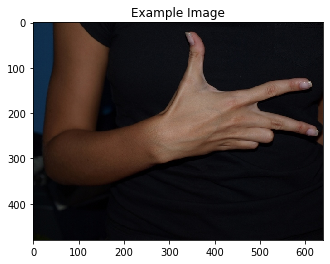

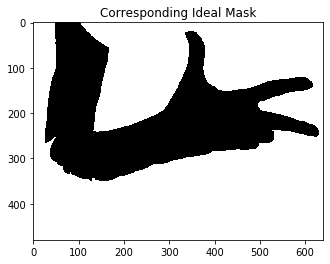

In [6]:
plt.title("Example Image")
plt.imshow(cv2.cvtColor(images['3_P_hgr1_id05_3'], cv2.COLOR_BGR2RGB))
plt.show()
plt.title("Corresponding Ideal Mask")
plt.imshow(cv2.cvtColor(masks['3_P_hgr1_id05_3'], cv2.COLOR_BGR2RGB))
plt.show()

### Functional Code

In [7]:
def modifyColorSpace(images, change):
    images_ = {}
    for key in images.keys():
        image = images[key].copy()
        image = cv2.cvtColor(image, change)
        images_[key] = image
    return images_

In [8]:
def removeChannels(images, channels):
    return {key: images[key][:,:,channels].copy() for key in images.keys()}

In [9]:
def skinDetection(image, mask, value = 255):
    mask_skin = mask != 0
    img = image.copy()
    img[mask_skin]= value
    return img

In [10]:
def nonSkinDetection(image, mask, value = 255):
    mask_non_skin = mask == 0
    img = image.copy()
    img[mask_non_skin] = value
    return img

In [11]:
def removeNoise(image):
    kernel_size = 5
    return cv2.GaussianBlur(image,(kernel_size, kernel_size),0)

In [12]:
def buildStatistics(values):
    mean = np.mean(values)
    std  = np.std(values)
    return mean, std

In [13]:
def getSkinPixels(image, mask):
    mask_skin = mask == 0
    img = image.copy()
    return list(img[mask_skin])

In [14]:
def skinCharacterization(images, masks, channels):
    stats = {}
    for i in range(channels):
        hist_values = []
        for key in images.keys():
            mask   = masks[key]
            image  = removeNoise(images[key].copy())
            values = getSkinPixels(image[:,:,i], mask[:,:,i])
            hist_values += values
        stats[i] = buildStatistics(hist_values)
    return stats

In [101]:
def pixelClassification(image, channels, stats):
    n,m,_ = image.shape
    image_copy = np.ones(image.shape, int)*255
    mask = None
    
    for k in range(channels):
        pos_values = (stats[k][0] - stats[k][1] <= image[:,:,k]) == (image[:,:,k] <= stats[k][0] + stats[k][1])
        image_copy[~pos_values,k] = 0
        #bitwise operator: AND  applied to channels
        if k > 1:     
            mask = mask & image_copy[:,:,k] 
        else:
            mask = image_copy[:,:,k]
    return 255-mask

In [98]:
def performanceAnalysis(images, masks, channels, stats):
    metrics = {'precision':0, 'recall':0}
        
    for key in images.keys():
        predicted_mask = pixelClassification(removeNoise(images[key]), channels, stats)
        target_mask = masks[key][:,:,0].copy()
        
        metrics['precision'] += precision_score(predicted_mask.flatten(), target_mask.flatten(), pos_label=0)
        metrics['recall']    += recall_score(predicted_mask.flatten(), target_mask.flatten(), pos_label=0)
    
    metrics = {key: metrics[key]/len(images)for key in metrics.keys()}
    metrics['f1_score']  = (2*metrics['precision']*metrics['recall'])/(metrics['precision']+metrics['recall'])
    
    return metrics

### RGB Color Space

In [88]:
skin_images = {}
for key in images.keys():
    skin_images[key] = skinDetection(images[key], masks[key])

In [18]:
non_skin_images = {}
for key in images.keys():
    non_skin_images[key] = nonSkinDetection(images[key], masks[key])

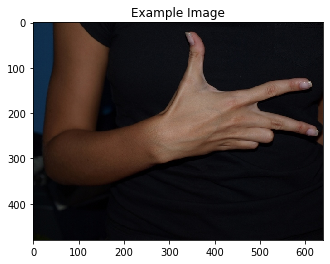

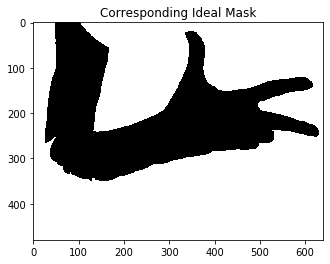

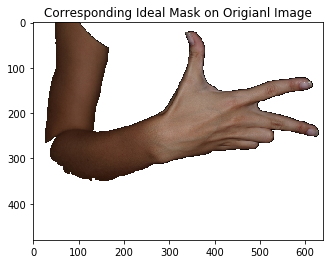

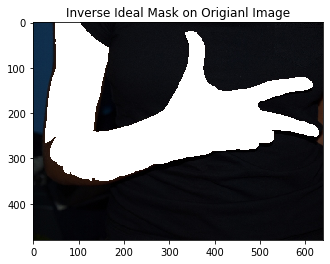

In [19]:
plt.title("Example Image")
plt.imshow(cv2.cvtColor(images['3_P_hgr1_id05_3'], cv2.COLOR_BGR2RGB))
plt.show()
plt.title("Corresponding Ideal Mask")
plt.imshow(cv2.cvtColor(masks['3_P_hgr1_id05_3'], cv2.COLOR_BGR2RGB))
plt.show()
plt.title("Corresponding Ideal Mask on Origianl Image")
plt.imshow(cv2.cvtColor(skin_images['3_P_hgr1_id05_3'], cv2.COLOR_BGR2RGB))
plt.show()
plt.title("Inverse Ideal Mask on Origianl Image")
plt.imshow(cv2.cvtColor(non_skin_images['3_P_hgr1_id05_3'], cv2.COLOR_BGR2RGB))
plt.show()

In [102]:
channels = 3
stats = skinCharacterization(images, masks, channels)

In [103]:
stats

{0: (77.52571496297023, 32.98278825497545),
 1: (93.10164425774171, 34.6588036071034),
 2: (128.00163475572407, 39.6794409411671)}

In [104]:
predicted_mask = pixelClassification(images['3_P_hgr1_id05_3'], channels, stats)

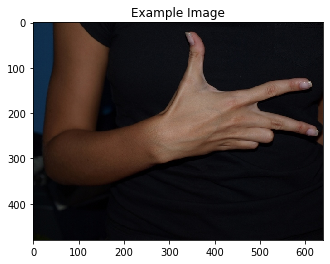

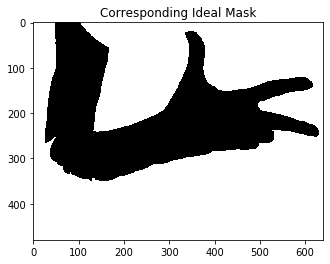

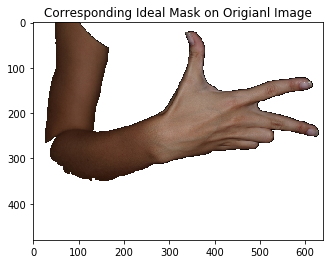

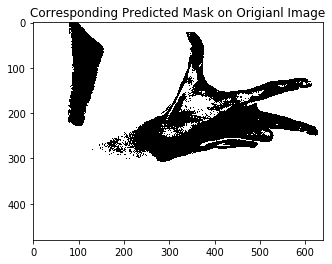

In [105]:
plt.title("Example Image")
plt.imshow(cv2.cvtColor(images['3_P_hgr1_id05_3'], cv2.COLOR_BGR2RGB))
plt.show()
plt.title("Corresponding Ideal Mask")
plt.imshow(cv2.cvtColor(masks['3_P_hgr1_id05_3'], cv2.COLOR_BGR2RGB))
plt.show()
plt.title("Corresponding Ideal Mask on Origianl Image")
plt.imshow(cv2.cvtColor(skin_images['3_P_hgr1_id05_3'], cv2.COLOR_BGR2RGB))
plt.show()
plt.title("Corresponding Predicted Mask on Origianl Image")
plt.imshow(predicted_mask, cmap='gray')
plt.show()

In [106]:
train_performance = performanceAnalysis(images, masks, 3, stats)

In [107]:
valid_performance = performanceAnalysis(valid_images, valid_masks, 3, stats)

In [108]:
print("Train:", train_performance)
print("Valid:", valid_performance)

Train: {'precision': 0.6192890750992942, 'recall': 0.6986779422947044, 'f1_score': 0.6565924806396233}
Valid: {'precision': 0.5187028991238094, 'recall': 0.43902511887978196, 'f1_score': 0.475549629269098}


### YCrCb Color Space

In [29]:
images_ycrcb = modifyColorSpace(images, cv2.COLOR_BGR2YCrCb)
valid_images_ycrcb = modifyColorSpace(valid_images, cv2.COLOR_BGR2YCrCb)

In [110]:
channels = 3
stats = skinCharacterization(images_ycrcb, masks, channels)

In [111]:
stats

{0: (101.76970455366316, 35.76493162724535),
 1: (146.75111457134406, 4.757146737333896),
 2: (114.31672038371804, 3.30925334723985)}

In [112]:
predicted_mask = pixelClassification(images_ycrcb['3_P_hgr1_id05_3'], channels, stats)

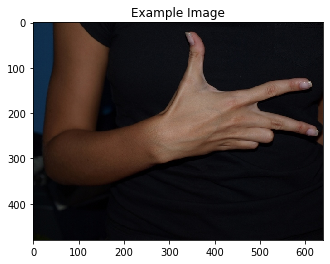

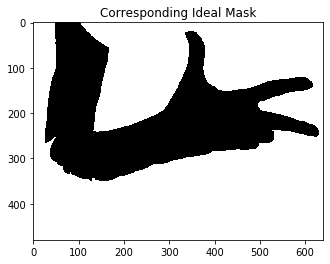

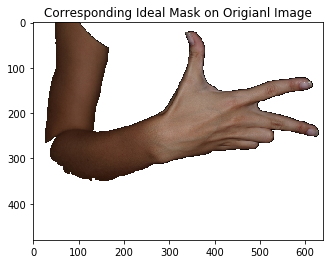

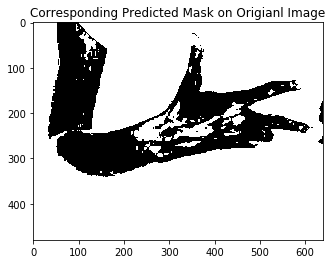

In [113]:
plt.title("Example Image")
plt.imshow(cv2.cvtColor(images['3_P_hgr1_id05_3'], cv2.COLOR_BGR2RGB))
plt.show()
plt.title("Corresponding Ideal Mask")
plt.imshow(cv2.cvtColor(masks['3_P_hgr1_id05_3'], cv2.COLOR_BGR2RGB))
plt.show()
plt.title("Corresponding Ideal Mask on Origianl Image")
plt.imshow(cv2.cvtColor(skin_images['3_P_hgr1_id05_3'], cv2.COLOR_BGR2RGB))
plt.show()
plt.title("Corresponding Predicted Mask on Origianl Image")
plt.imshow(predicted_mask, cmap='gray')
plt.show()

In [114]:
train_performance = performanceAnalysis(images_ycrcb, masks, 3, stats)

In [115]:
valid_performance = performanceAnalysis(valid_images_ycrcb, valid_masks, 3, stats)

In [37]:
print("Train:", train_performance)
print("Valid:", valid_performance)

Train: {'precision': 0.8422654532748646, 'recall': 0.8349587110225758, 'f1_score': 0.838596166422165}
Valid: {'precision': 0.7911659481911232, 'recall': 0.9114159498281417, 'f1_score': 0.8470444387799262}


**CrCb Componets**

In [117]:
images_crcb = removeChannels(images_ycrcb, [1,2])
valid_images_crcb = removeChannels(valid_images_ycrcb, [1,2])

In [118]:
channels = 2
stats = skinCharacterization(images_crcb, masks, channels)

In [119]:
stats

{0: (146.75111457134406, 4.757146737333896),
 1: (114.31672038371804, 3.30925334723985)}

In [120]:
predicted_mask = pixelClassification(images_crcb['3_P_hgr1_id05_3'], channels, stats)

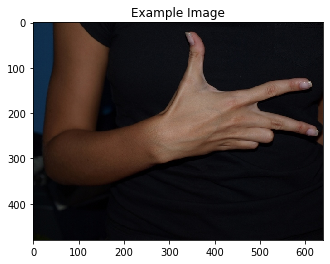

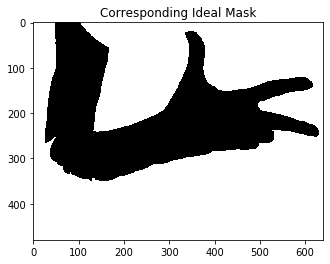

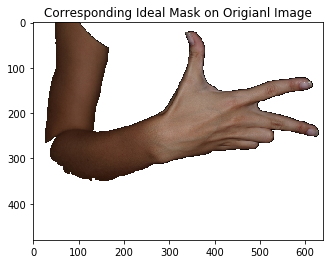

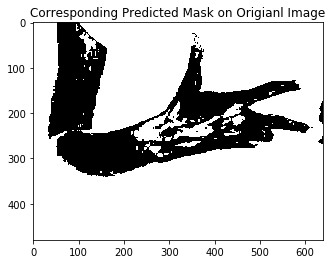

In [274]:
plt.title("Example Image")
plt.imshow(cv2.cvtColor(images['3_P_hgr1_id05_3'], cv2.COLOR_BGR2RGB))
plt.show()
plt.title("Corresponding Ideal Mask")
plt.imshow(cv2.cvtColor(masks['3_P_hgr1_id05_3'], cv2.COLOR_BGR2RGB))
plt.show()
plt.title("Corresponding Ideal Mask on Origianl Image")
plt.imshow(cv2.cvtColor(skin_images['3_P_hgr1_id05_3'], cv2.COLOR_BGR2RGB))
plt.show()
plt.title("Corresponding Predicted Mask on Origianl Image")
plt.imshow(predicted_mask, cmap='gray')
plt.show()

In [122]:
train_performance = performanceAnalysis(images_crcb, masks, 2, stats)

In [123]:
valid_performance = performanceAnalysis(valid_images_crcb, valid_masks, 2, stats)

In [124]:
print("Train:", train_performance)
print("Valid:", valid_performance)

Train: {'precision': 0.7167047540391321, 'recall': 0.9059043122528819, 'f1_score': 0.8002740041135026}
Valid: {'precision': 0.6537392620825013, 'recall': 0.9122035369496231, 'f1_score': 0.7616411882772236}


### Morphological Operator